In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft
from ipywidgets import interact
import pandas as pd
import seaborn as sns
from scipy.signal import lfilter
from scipy.stats import linregress
import chess
import chess.svg
from IPython.display import display, SVG, clear_output

In [2]:
data = np.load("train_new.npy")
data.shape

(8, 8, 12220)

### Displaying data within a block

In [3]:
def plot_time_series(spatial_index, data):
    time_series = data[spatial_index[0], spatial_index[1], :]
    plt.figure(figsize=(20, 16))  # Set the figure size

    plt.plot(range(1, data.shape[2] + 1), time_series, label=f'Spatial Index {spatial_index}', linewidth=0.2)
    plt.xlabel('Sample Index')
    plt.ylabel('Value')
    plt.title(f'Time Series for Spatial Index {spatial_index}')
    plt.legend()
    plt.show()

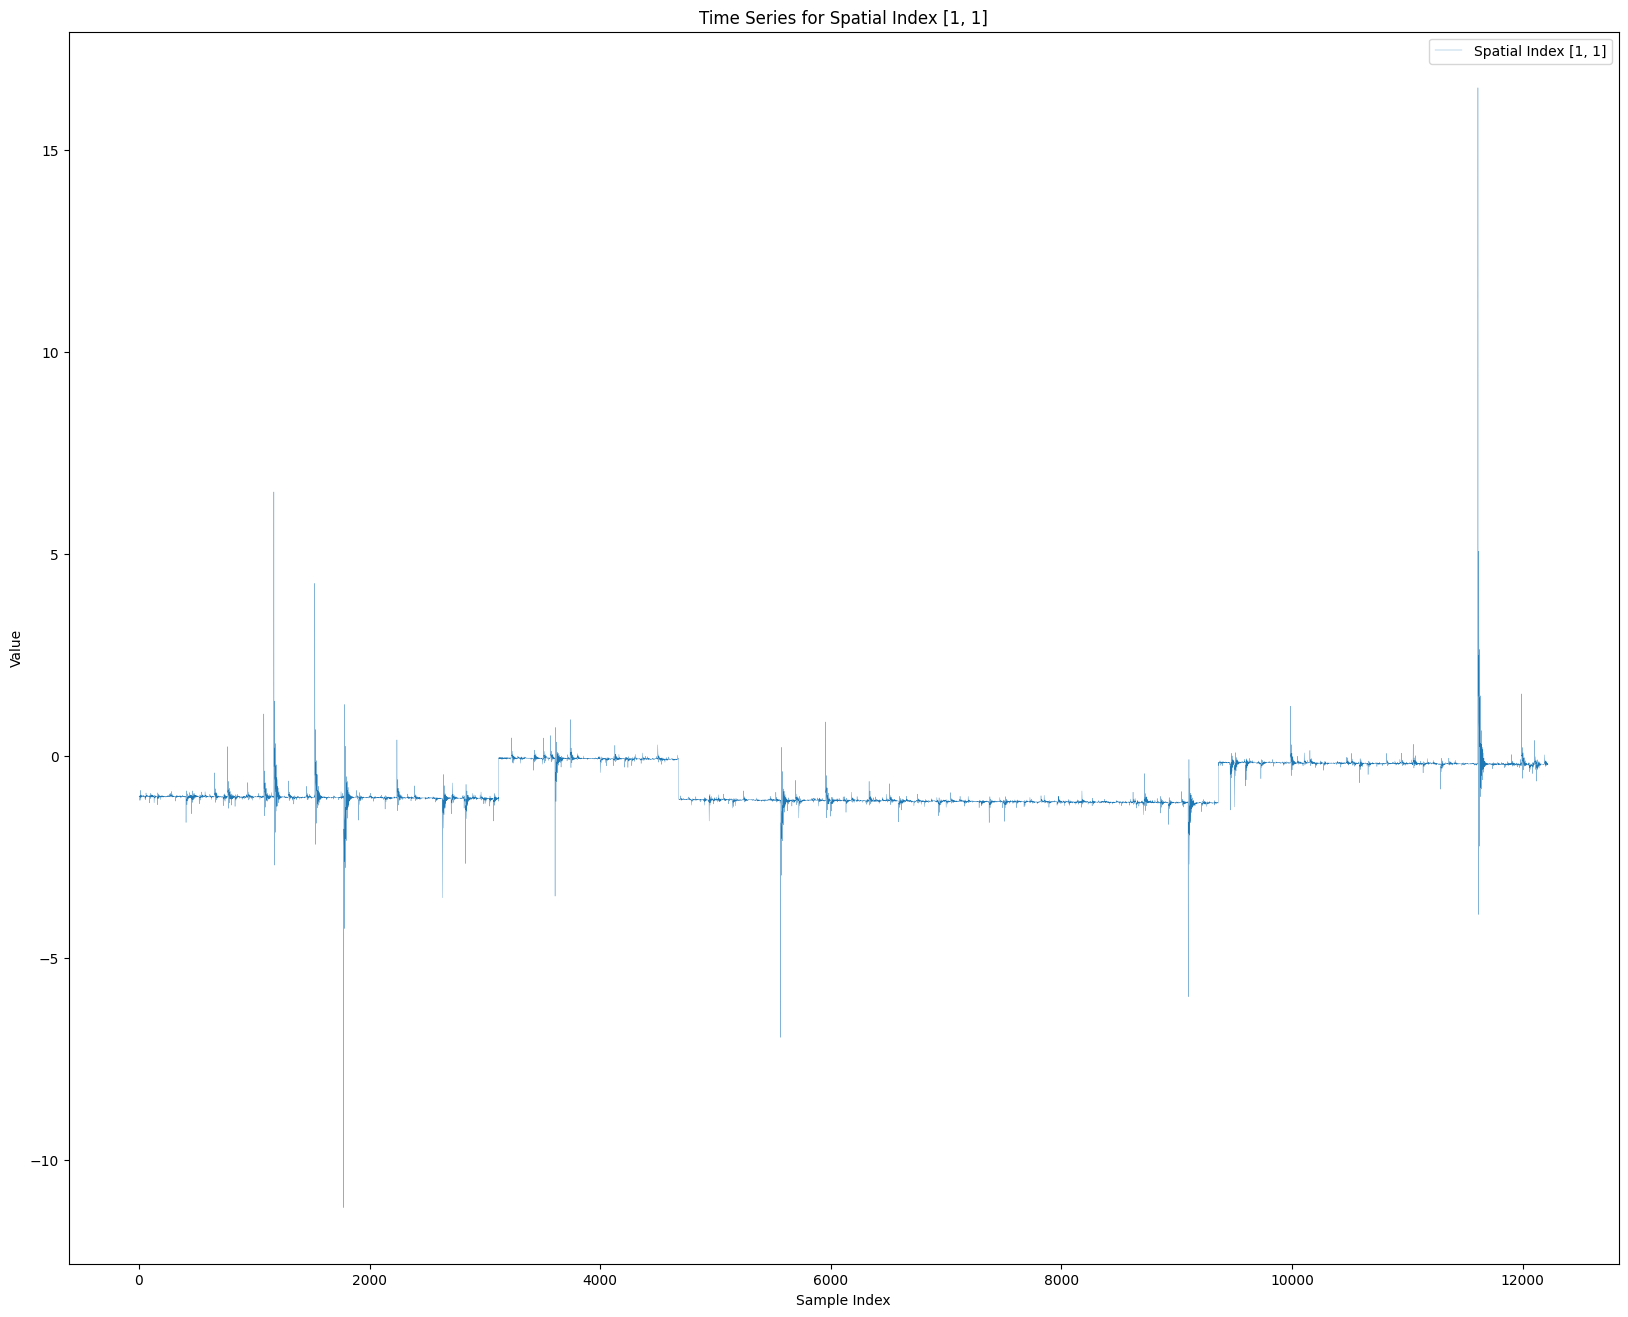

In [4]:
plot_time_series([1,1], data)

### Basic Outlier removement

In [5]:
data_without_oultier_simple = data.copy()
mask = (data_without_oultier_simple >= 1.5) | (data_without_oultier_simple <= -1.5)

data_without_oultier_simple[mask] = np.nan

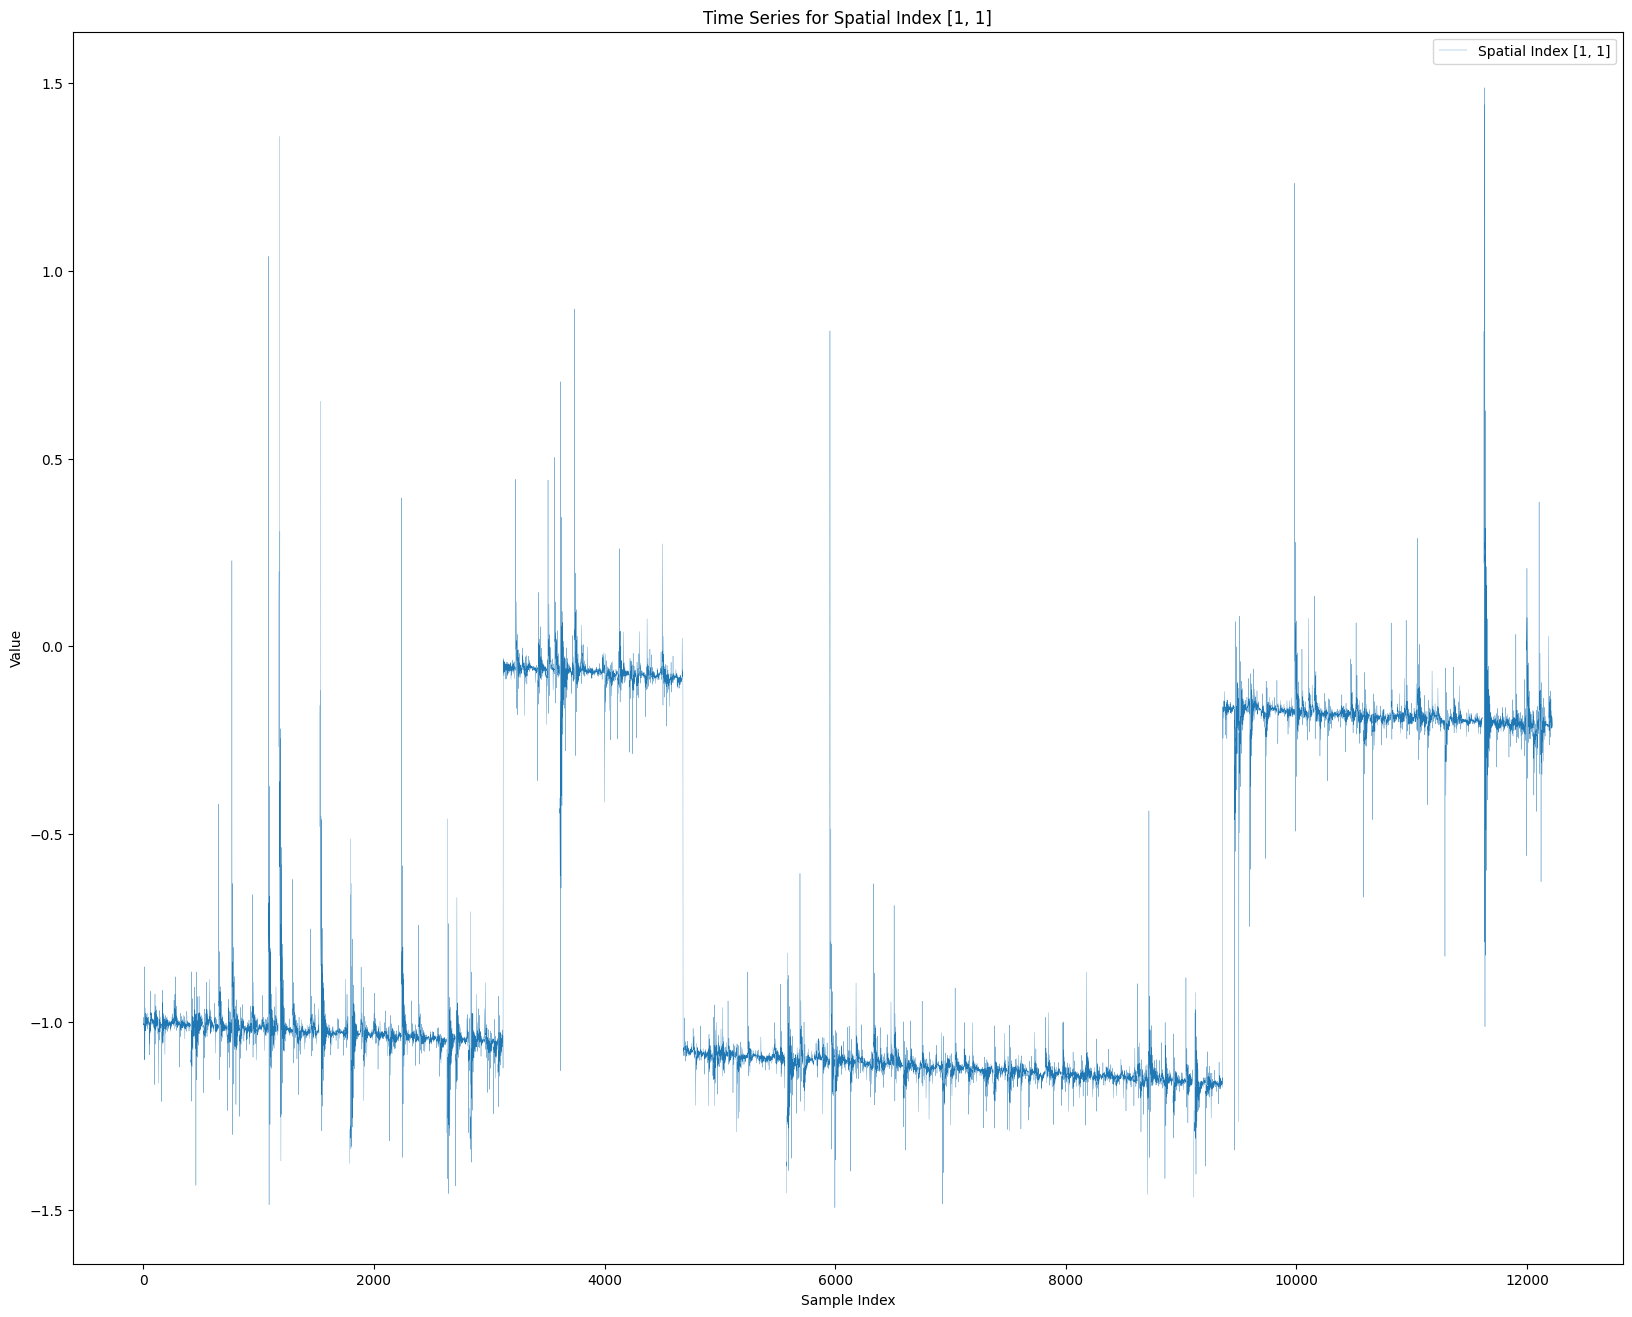

In [6]:
plot_time_series([1,1], data_without_oultier_simple)

### Visualicing the first 46 moves

In [7]:
data_new = data.copy()

block = 0
res = np.zeros((8, 8, 47))
for row in range(8):
    
    for col in range(8):

        block = np.clip(data_new[row,col,:], -1, 1)
        for n in range(47):
            res[row,col,n] = np.rint(np.mean(block[260*n:260*n+259]))


result = res


def conf_matrix(data):

    def plot_frame(frame):
        fig, ax = plt.subplots()
        im = ax.imshow(data[:, :, frame], cmap='viridis', interpolation='nearest', extent=[0.5, 8.5, 8.5, 0.5])
        plt.title(f"Frame {frame + 1}")
        plt.colorbar(im)
        
        for i in range(8):
            for j in range(8):
                value = data[i, j, frame]
                plt.text(j + 1, i + 1, f'{value:.2f}', color='white', ha='center', va='center', fontsize=8)

        plt.xticks(range(1, 9))
        plt.yticks(range(1, 9))
        plt.show()

    # Create an interactive scroller
    interact(plot_frame, frame=(0, data.shape[2] - 1, 1))

In [8]:
conf_matrix(res)

interactive(children=(IntSlider(value=23, description='frame', max=46), Output()), _dom_classes=('widget-inter…

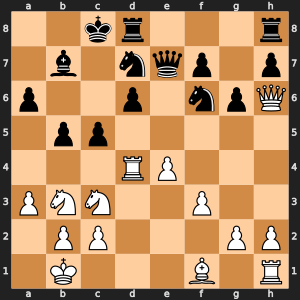

In [9]:
def create_board_from_data(data_frame):
    board = chess.Board(None)  # Create an empty board
    for i in range(8):
        for j in range(8):
            value = data_frame[i, j]
            square = chess.square(j, 7 - i)  # Flip the row index for the chess library
            
            # Assign pieces based on the value in the position
            if i == 1 and value == -1:  # Black pawns
                board.set_piece_at(square, chess.Piece(chess.PAWN, chess.BLACK))
            elif i == 6 and value == 1:  # White pawns
                board.set_piece_at(square, chess.Piece(chess.PAWN, chess.WHITE))
            elif i == 0 and value == -1:  # Black non-pawn pieces
                piece_type = [chess.ROOK, chess.KNIGHT, chess.BISHOP, chess.QUEEN, 
                              chess.KING, chess.BISHOP, chess.KNIGHT, chess.ROOK][j]
                board.set_piece_at(square, chess.Piece(piece_type, chess.BLACK))
            elif i == 7 and value == 1:  # White non-pawn pieces
                piece_type = [chess.ROOK, chess.KNIGHT, chess.BISHOP, chess.QUEEN, 
                              chess.KING, chess.BISHOP, chess.KNIGHT, chess.ROOK][j]
                board.set_piece_at(square, chess.Piece(piece_type, chess.WHITE))
    
    return board

def find_from_square(current_frame, previous_frame, to_square, board):
    for i in range(8):
        for j in range(8):
            if previous_frame[i, j] != 0 and current_frame[i, j] == 0:
                from_square = chess.square(j, 7 - i)
                if chess.Move(from_square, to_square) in board.legal_moves:
                    return from_square
    return None


def update_board(current_frame, previous_frame, board):
    # First, handle the castling case
    # Example for white, adapt for black by checking the respective rows and columns
    if previous_frame[7, 4] != 0 and current_frame[7, 4] == 0:  # Indicates the white king moved
        if previous_frame[7, 6] == 0 and current_frame[7, 6] != 0:  # Kingside castling
            castling_move = chess.Move(chess.E1, chess.G1)
            if castling_move in board.legal_moves:
                board.push(castling_move)
                return  # No need to check other squares as castling is a unique move
        elif previous_frame[7, 2] == 0 and current_frame[7, 2] != 0:  # Queenside castling
            castling_move = chess.Move(chess.E1, chess.C1)
            if castling_move in board.legal_moves:
                board.push(castling_move)
                return  # No need to check other squares as castling is a unique move
    
        # Handle the castling case for black
    if previous_frame[0, 4] != 0 and current_frame[0, 4] == 0:  # Indicates the black king moved
        if previous_frame[0, 6] == 0 and current_frame[0, 6] != 0:  # Kingside castling
            castling_move = chess.Move(chess.E8, chess.G8)
            if castling_move in board.legal_moves:
                board.push(castling_move)
                return  # No need to check other squares as castling is a unique move
        elif previous_frame[0, 2] == 0 and current_frame[0, 2] != 0:  # Queenside castling
            castling_move = chess.Move(chess.E8, chess.C8)
            if castling_move in board.legal_moves:
                board.push(castling_move)
                return  # No need to check other squares as castling is a unique move
            
    # Continue with normal moves
    for i in range(8):
        for j in range(8):
            current_value = current_frame[i, j]
            previous_value = previous_frame[i, j]
            to_square = chess.square(j, 7 - i)

            if current_value != previous_value:
                if current_value != 0:  # A piece has appeared here
                    from_square = find_from_square(current_frame, previous_frame, to_square, board)
                    if from_square:
                        move = chess.Move(from_square, to_square)
                        if move in board.legal_moves:
                            board.push(move)
    


# Specify the desired size (in pixels)
size = 300

# Initialize the board to the standard starting position
initial_board = chess.Board()
print("Starting Board")

# Display the initial board
board_svg = chess.svg.board(initial_board, size=size)
display(SVG(board_svg))


for i in range(res.shape[2]):
    previous_frame = res[:, :, i - 1]
    current_frame = res[:, :, i]
    update_board(current_frame, previous_frame, initial_board)
    
    clear_output(wait=True)

    # Display the board as an SVG
    board_svg = chess.svg.board(initial_board, size=size)
    display(SVG(board_svg))
    
    # Pause for the user to check the board
    input("Press Enter to continue to the next move...")

### Filling the test set with the correct continuation of moves

In [9]:
pred_ = np.load("dummy_test_dataset.npy")
print(pred_.shape)

(8, 8, 10660)


In [10]:
moves = [[7,3, 4,3],
         [3,2, 4,3],
         [7,4, 1,4],
         [1,0, 2,1],
         [4,5, 4,3],
         [2,1, 3,0],
         [6,1, 4,1],
         [3,0, 4,0],
         [4,3, 5,2],
         [2,3, 3,3],
         [1,4, 1,0],
         [0,0, 1,1],
         [1,0, 1,1],
         [3,3, 4,2],
         [5,2, 2,5],
         [4,0, 5,0],
         [2,5, 2,0],
         [5,0, 4,1],
         [6,2, 5,2],
         [4,1, 5,2],
         [2,0, 7,0],
         [5,2, 6,3],
         [7,0, 6,1],
         [6,3, 7,3],
         [5,7, 7,5],
         [0,3, 6,3],
         [1,1, 1,3],
         [6,3, 1,3],
         [7,5, 4,2],
         [3,1, 4,2],
         [6,1, 0,7],
         [1,3, 5,3],
         [0,7, 0,0],
         [4,2, 5,2],
         [0,0, 4,0],
         [7,3, 7,4],
         [5,5, 4,5],
         [1,5, 3,5],
         [7,1, 7,2],
         [5,3, 6,3],
         [4,0, 1,0]
         ]

In [11]:
for j in range(260):        
    pred_[:,:,j] = result[:,:,46]

print(result[0,0,46])
for i in range(41):
    value = 0
    if i%2==0: value = 1
    else: value = -1 

    for j in range(260): 
        
        pred_[moves[i][0],moves[i][1],260*i+j] = 0
        pred_[moves[i][2],moves[i][3],260*i+j] = value

    if i < 40:
        pred_[:,:,(i+1)*260:(i+1)*260+260] = pred_[:,:,i*260:i*260+260]

pred_[:,:,10659] = pred_[:,:,10658]

#np.save("prediction.npy", pred_)

-1.0


In [12]:
conf_matrix(pred_)

interactive(children=(IntSlider(value=5329, description='frame', max=10659), Output()), _dom_classes=('widget-…

### Adding linear trend

In [13]:
spatial_index = (5,0)

selected_data = data_without_oultier_simple[spatial_index[0], spatial_index[1]].copy()
selected_data = selected_data[:]

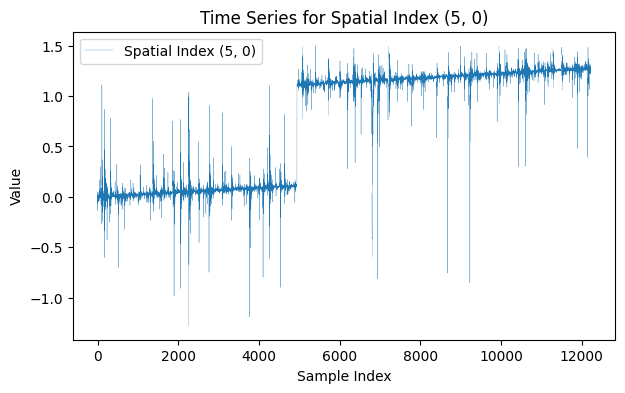

In [14]:
plt.figure(figsize=(7, 4))  # Set the figure size
plt.plot(range(1, len(selected_data) + 1), selected_data, label=f'Spatial Index {spatial_index}', linewidth=0.2)
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.title(f'Time Series for Spatial Index {spatial_index}')
plt.legend()
plt.show()

In [15]:
nan_indices = np.isnan(selected_data)

selected_data_without_nan = selected_data[~nan_indices]

In [16]:
y_values = selected_data_without_nan[:] 
x_values = np.arange(len(y_values))

slope, intercept, r_value, p_value, std_err = linregress(x_values, y_values)
slope

0.00014056168908029774

In [17]:
def get_slope(data, spatial_index, interval, plot=False):

    selected_data = data[spatial_index[0], spatial_index[1]].copy()
    
    nan_indices = np.isnan(selected_data)
    print(len(nan_indices))
    selected_data = selected_data[~nan_indices]
    selected_data = selected_data[interval[0]:interval[1]]    

    y_values = selected_data 
    x_values = np.arange(len(y_values))

    slope, intercept, r_value, p_value, std_err = linregress(x_values, y_values)
    print(slope)

    linear_function = lambda x: slope * x + intercept

    x_linear_function = np.linspace(0, len(y_values) - 1, num=1000)
    y_linear_function = linear_function(x_linear_function)

    if plot:
        plt.figure(figsize=(12, 8)) 
        plt.plot(range(1, len(selected_data) + 1), selected_data, label=f'Spatial Index {spatial_index}', linewidth=0.2)
        plt.plot(x_linear_function, y_linear_function, color='red', label=f'Linear Function: y = {slope:.6f}x + {intercept:.2f}')

        plt.xlabel('Sample Index')
        plt.ylabel('Value')
        plt.title(f'Time Series for Spatial Index {spatial_index}')
        plt.legend()
        plt.show()
    
    return slope

12220
-1.8735782615789028e-05


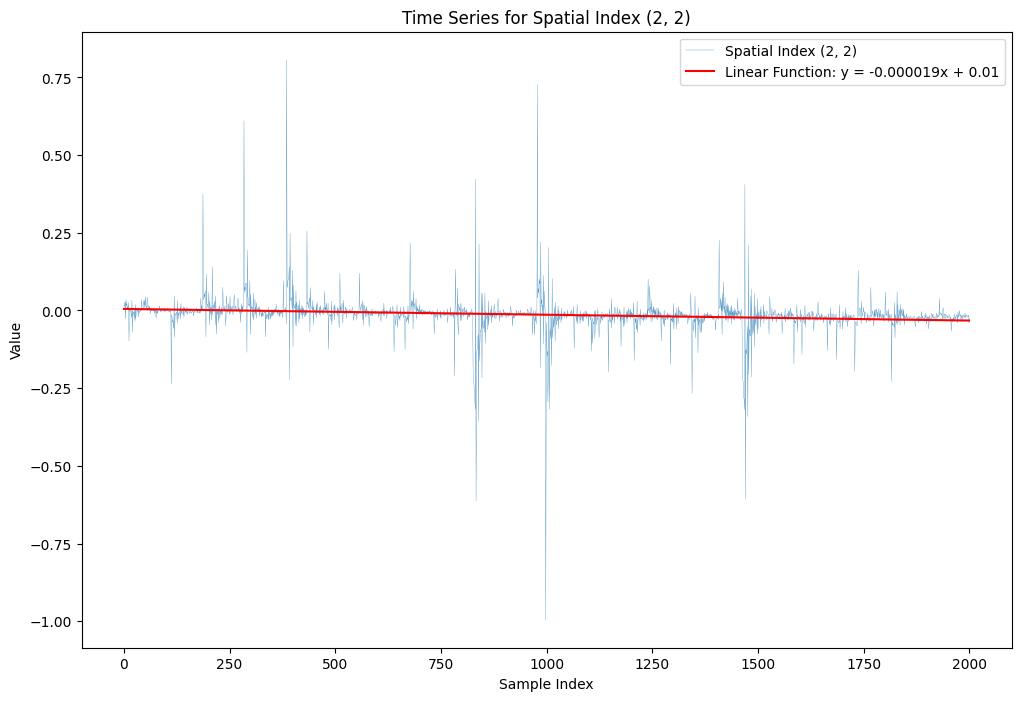

-1.8735782615789028e-05

In [18]:
get_slope(data_without_oultier_simple,(2,2), (0,2000), True)
#get_slope(data_without_oultier_simple,(1,1), (5000,9000), True)
#get_slope(data_without_oultier_simple,(1,1), (0,3000), True)
#get_slope(data_without_oultier_simple,(1,1), (9500,12000), True)

### Calculate slope for all fields

In [19]:
def get_linear_funciton(data, spatial_index, plot=False):

    selected_data = data[spatial_index[0], spatial_index[1]]

    y_values = selected_data 
    x_values = np.arange(len(y_values))

    slope, intercept, r_value, p_value, std_err = linregress(x_values, y_values)
    #print(slope)

    linear_function = lambda x: slope * x + intercept

    x_linear_function = np.linspace(0, len(y_values) - 1, num=1000)
    y_linear_function = linear_function(x_linear_function)

    if plot:
        plt.figure(figsize=(12, 8)) 
        plt.plot(range(1, len(selected_data) + 1), selected_data, label=f'Spatial Index {spatial_index}', linewidth=0.2)
        plt.plot(x_linear_function, y_linear_function, color='red', label=f'Linear Function: y = {slope:.6f}x + {intercept:.2f}')

        plt.xlabel('Sample Index')
        plt.ylabel('Value')
        plt.title(f'Time Series for Spatial Index {spatial_index}')
        plt.legend()
        plt.show()
    
    return slope, intercept

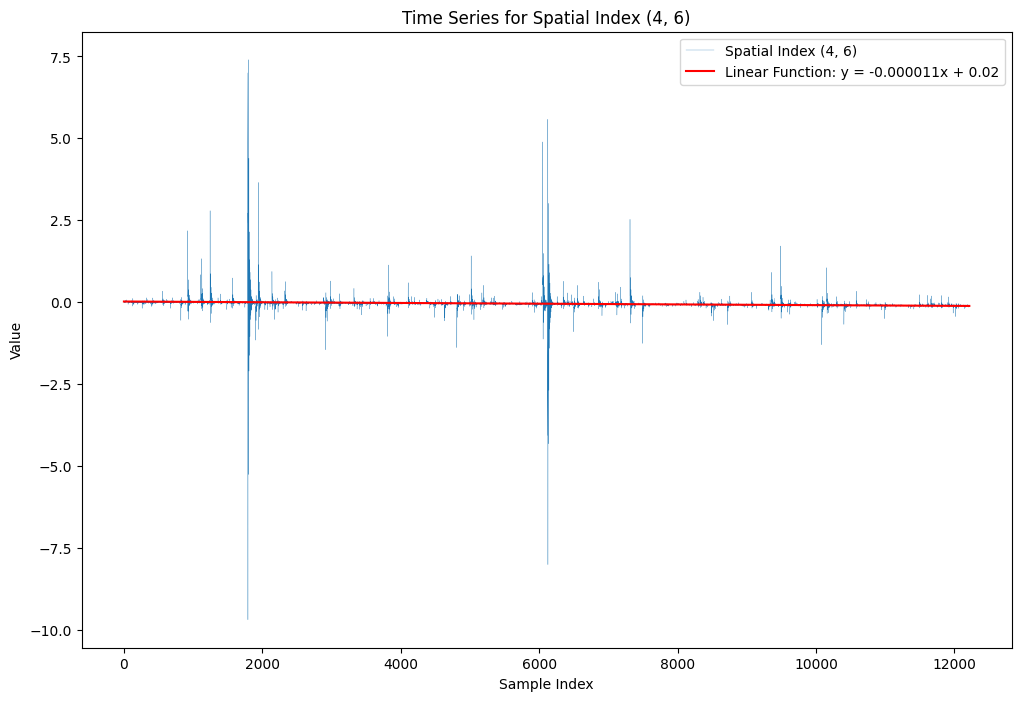

(-1.1067212093781923e-05, 0.01734284028561233)

In [20]:
clean_moves = result.copy()
clean_data = data.copy()
cleaned_data = np.empty((8, 8), dtype=object)

# substract moves to get linear data
for i in range(46):
    for j in range(260):
        clean_data[:,:,260*i+j] -= clean_moves[:,:,i]

# remove outliers
mask = (clean_data >= 10) | (clean_data <= -10)
clean_data[mask] = np.nan

# remove nan

for i in range(clean_data.shape[0]):
    for j in range(clean_data.shape[1]):
        tmp = clean_data[i,j]
        nan_indices = np.isnan(tmp)
        tmp = tmp[~nan_indices] 
        cleaned_data[i,j] = tmp

#print(cleaned_data[1,1].shape)
get_linear_funciton(cleaned_data,(4,6), True)


In [21]:
linear_functions = np.zeros((8,8,2))

for i in range(cleaned_data.shape[0]):
    for j in range(cleaned_data.shape[1]):
        linear_functions[i,j] = get_linear_funciton(cleaned_data, (i,j))

print(linear_functions.shape)

(8, 8, 2)


In [22]:
improvedpred = pred_.copy()

for i in range(improvedpred.shape[0]):
    for j in range(improvedpred.shape[1]):
        for x in range(improvedpred.shape[2]):
            improvedpred[i,j,x] = improvedpred[i,j,x] + linear_functions[i,j,0]*(x+12220) - linear_functions[i,j,0]


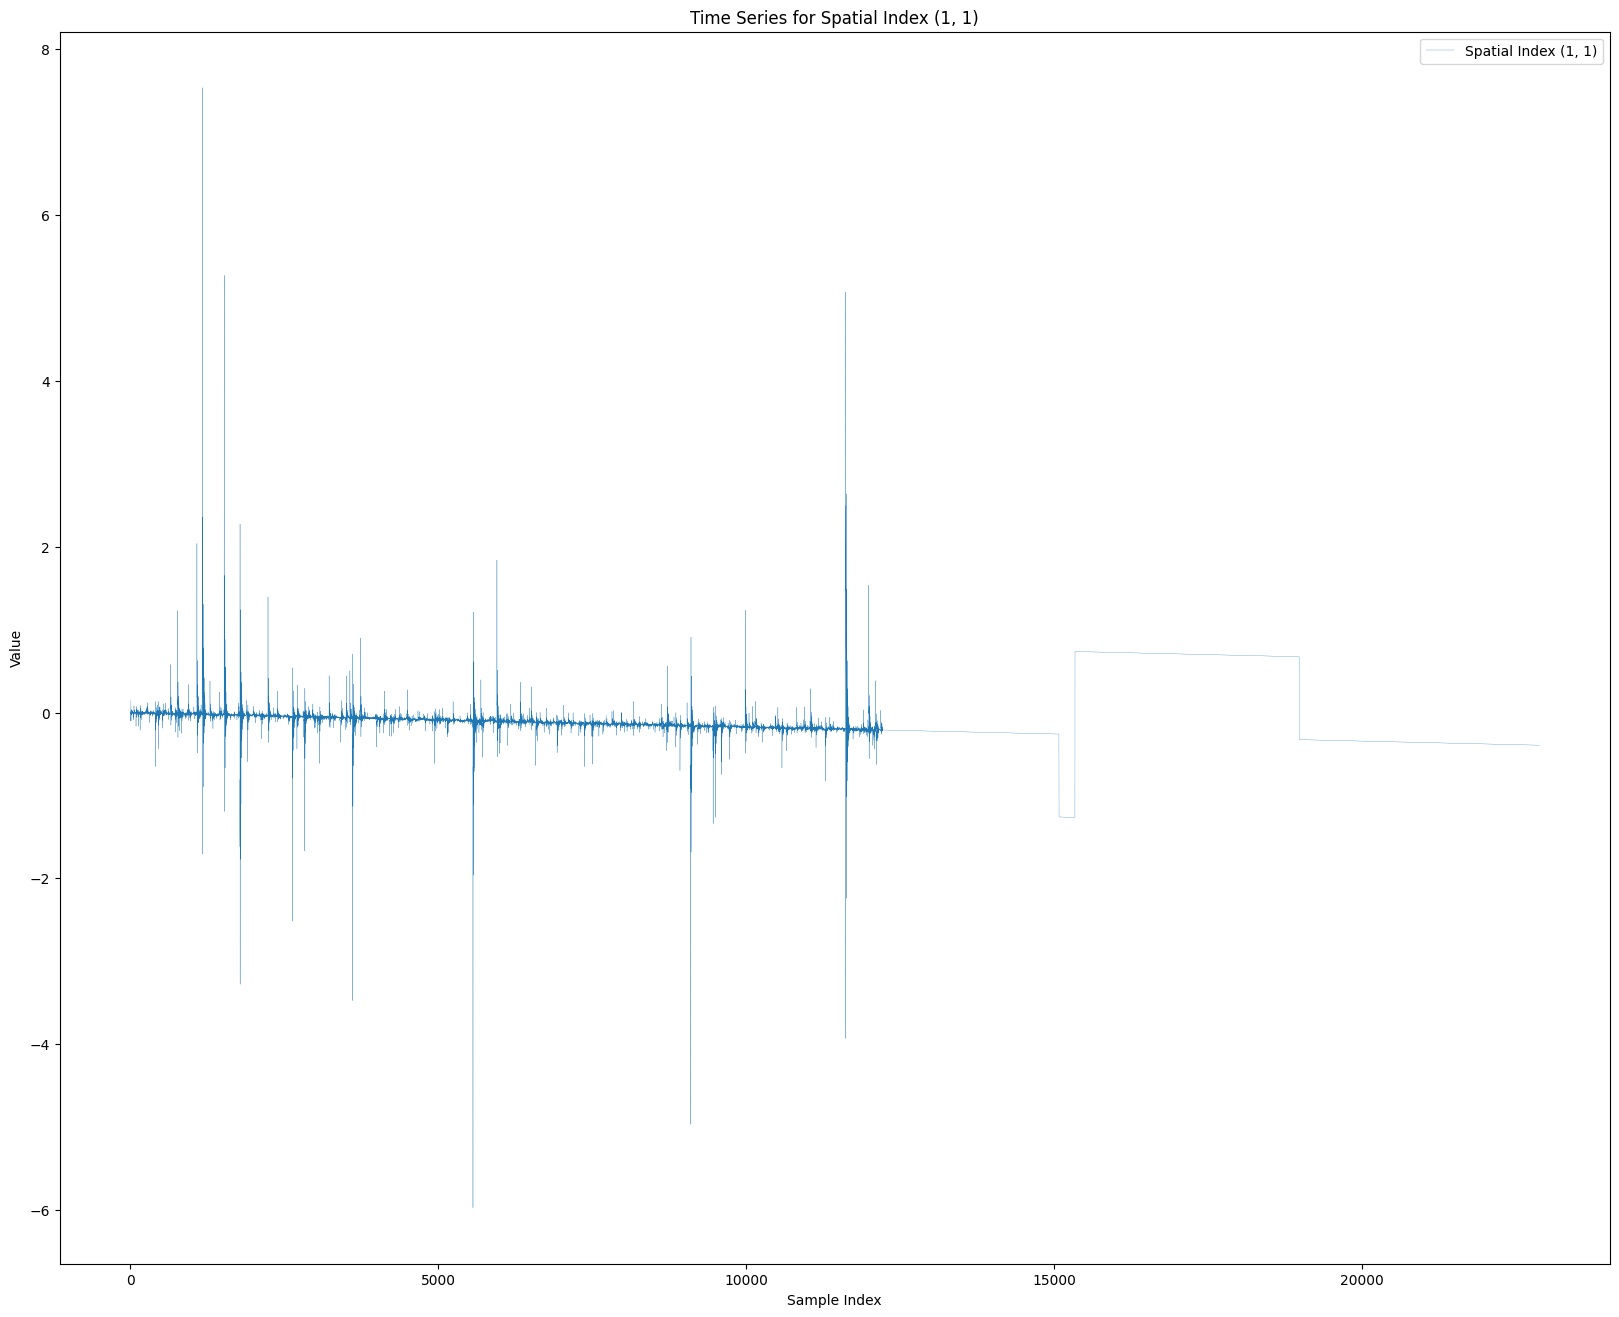

In [23]:
np.save("prediction.npy", improvedpred)
total_data = np.concatenate((clean_data, improvedpred), axis=2)
plot_time_series((1,1), total_data)

### Visualizations

In [24]:
# Calculate the mean for each of the 64 values over the last 100 instances
means_last_100 = np.mean(data_without_oultier_simple[:, :, -100:], axis=2)

# Create a new 8x8x10660 array filled with the calculated means
last_values = np.tile(means_last_100[:, :, np.newaxis], (1, 1, 10660))
last_values.shape

(8, 8, 10660)

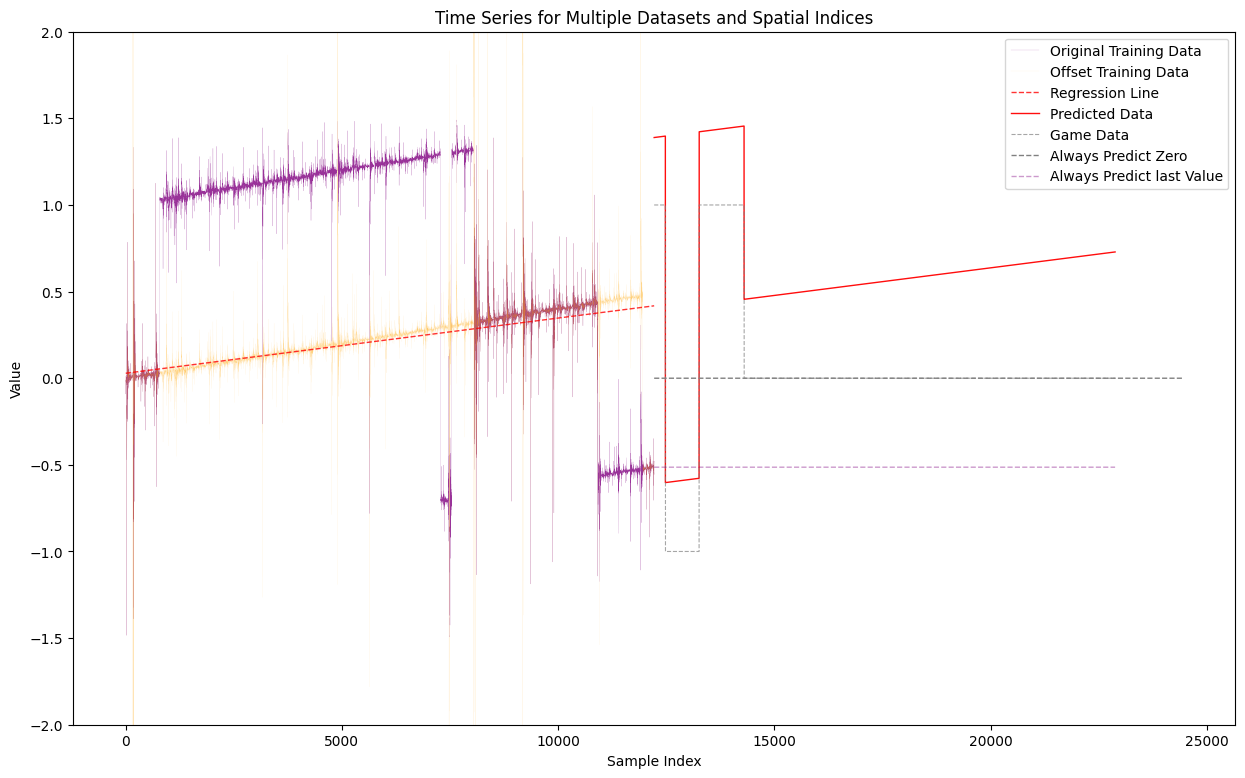

In [27]:
import matplotlib.pyplot as plt

def plot_time_series_multi(spatial_indices, data_without_oultier_simple, clean_data, cleaned_data,total_data, pred_, last_values):
    plt.figure(figsize=(15, 9))  # Set the figure size

    time_series = data_without_oultier_simple[spatial_indices[0], spatial_indices[1], :]

    if data_without_oultier_simple is not None:
        time_series1 = data_without_oultier_simple[spatial_indices[0], spatial_indices[1], :]
        plt.plot(range(1, data_without_oultier_simple.shape[2] + 1), time_series1, label='Original Training Data', color='Purple', alpha=0.8, linewidth=0.1)

  
    time_series2 = clean_data[spatial_indices[0], spatial_indices[1], :]
    plt.plot(range(1, clean_data.shape[2] + 1), time_series2, label='Offset Training Data', color='orange', alpha=0.6, linewidth=0.05)


    linear_funciton = get_linear_funciton(cleaned_data,spatial_indices)
    slope, intercept = linear_funciton
    x_values = range(1, data_without_oultier_simple.shape[2] + 1)
    y_values = [slope * x + intercept for x in x_values]
    plt.plot(x_values, y_values, label='Regression Line', color='red', linestyle='--', alpha = 0.8, linewidth=1)


    # time_series4 = data_set4[spatial_indices[0], spatial_indices[1], :]
    # plt.plot(range(1, data_set4.shape[2] + 1), time_series4, label='Dataset 2', color='green', alpha=0.45, linewidth=0.2)

    # predictions
    start_index = 12220
    total_slice = total_data[:, :, start_index:]
    plt.plot(range(start_index, start_index + total_slice.shape[2]), total_slice[spatial_indices[0], spatial_indices[1], :].flatten(), label='Predicted Data', color='red', alpha=0.95, linewidth=1)

    #game data 
    start_index = 12220
    pred_slice = pred_[:, :, start_index - 12220:]
    pred_flattened = pred_slice[spatial_indices[0], spatial_indices[1], :].flatten()
    plt.plot(range(start_index, start_index + len(pred_flattened)), pred_flattened, label='Game Data', color='grey', alpha=0.7, linewidth=0.8, linestyle='--')


    #always predict 0
    zero_array = np.zeros((8, 8, 12220), dtype=float)
    plt.plot(range(start_index, start_index + zero_array.shape[2]), zero_array[spatial_indices[0], spatial_indices[1], :].flatten(), label='Always Predict Zero', color='gray', linestyle='--', linewidth=1)

    #last values
    plt.plot(range(start_index, start_index + last_values.shape[2]), last_values[spatial_indices[0], spatial_indices[1], :].flatten(), label='Always Predict last Value', color='purple', linestyle='--', linewidth=1, alpha = 0.4)

    plt.xlabel('Sample Index')
    plt.ylabel('Value')
    plt.title('Time Series for Multiple Datasets and Spatial Indices')
    plt.legend()
    plt.ylim(-2, 2)  # Set the y-axis limits
    plt.show()

# Example usage:
# Assuming data_set1 and clean_data are your datasets
# and (4, 3) is your spatial index


plot_time_series_multi((4,3), data_without_oultier_simple, clean_data, cleaned_data, total_data, pred_, last_values )

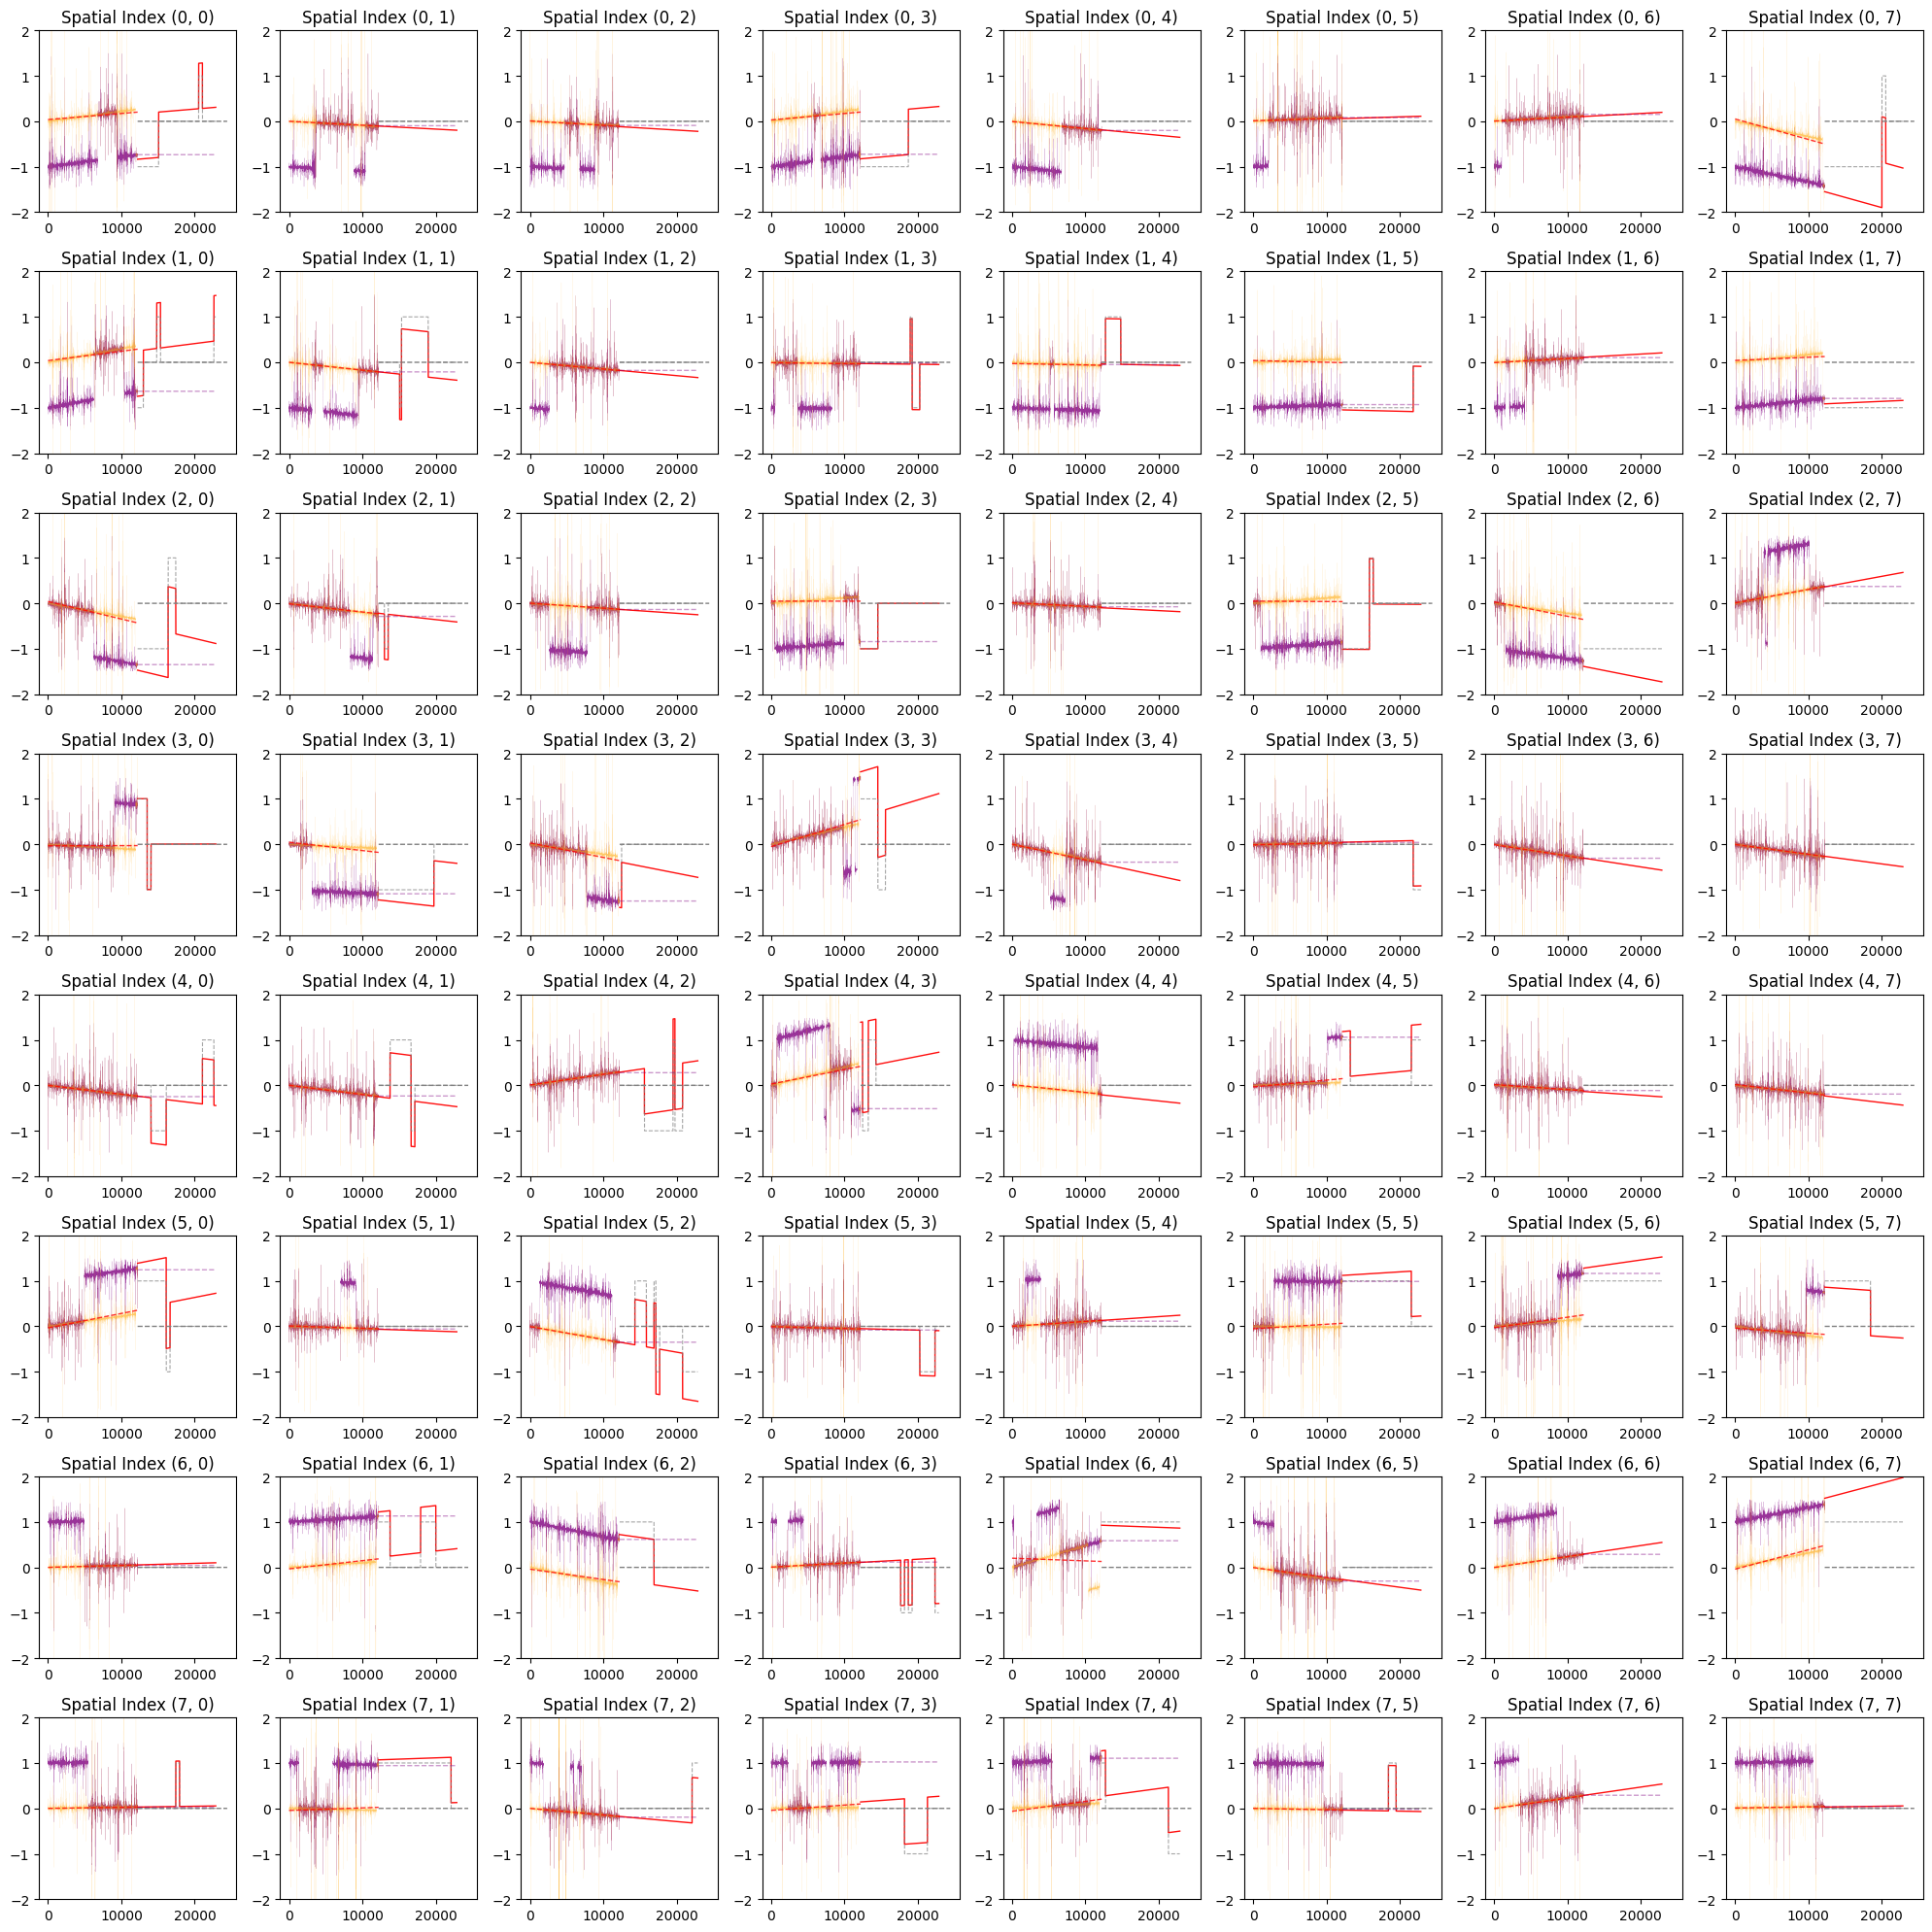

In [29]:
import numpy as np
import matplotlib.pyplot as plt


fig, axs = plt.subplots(8, 8, figsize=(20, 20))

for i in range(8):
    for j in range(8):
        spatial_indices = (i, j)
        ax = axs[i, j]

        # Your existing plotting code
        time_series = data_without_oultier_simple[spatial_indices[0], spatial_indices[1], :]
        time_series1 = data_without_oultier_simple[spatial_indices[0], spatial_indices[1], :]
        ax.plot(range(1, data_without_oultier_simple.shape[2] + 1), time_series1, label='Original Training Data', color='Purple', alpha=0.8, linewidth=0.1)

        time_series2 = clean_data[spatial_indices[0], spatial_indices[1], :]
        ax.plot(range(1, clean_data.shape[2] + 1), time_series2, label='Offset Training Data', color='orange', alpha=0.6, linewidth=0.05)

        linear_funciton = get_linear_funciton(cleaned_data, spatial_indices)
        slope, intercept = linear_funciton
        x_values = range(1, data_without_oultier_simple.shape[2] + 1)
        y_values = [slope * x + intercept for x in x_values]
        ax.plot(x_values, y_values, label='Regression Line', color='red', linestyle='--', alpha=0.8, linewidth=1)

        start_index = 12220
        total_slice = total_data[:, :, start_index:]
        ax.plot(range(start_index, start_index + total_slice.shape[2]), total_slice[spatial_indices[0], spatial_indices[1], :].flatten(), label='Predicted Data', color='red', alpha=0.95, linewidth=1)

        start_index = 12220
        pred_slice = pred_[:, :, start_index - 12220:]
        pred_flattened = pred_slice[spatial_indices[0], spatial_indices[1], :].flatten()
        ax.plot(range(start_index, start_index + len(pred_flattened)), pred_flattened, label='Game Data', color='grey', alpha=0.7, linewidth=0.8, linestyle='--')

        zero_array = np.zeros((8, 8, 12220), dtype=float)
        ax.plot(range(start_index, start_index + zero_array.shape[2]), zero_array[spatial_indices[0], spatial_indices[1], :].flatten(), label='Always Predict Zero', color='gray', linestyle='--', linewidth=1)

        ax.plot(range(start_index, start_index + last_values.shape[2]), last_values[spatial_indices[0], spatial_indices[1], :].flatten(), label='Always Predict last Value', color='purple', linestyle='--', linewidth=1, alpha=0.4)

        ax.set_title(f'Spatial Index {spatial_indices}')

        # Set the y-axis limits
        ax.set_ylim(-2, 2)

        # Add legend to the subplot
        #ax.legend()

plt.tight_layout()
plt.show()
